In [3]:
# First, we need to install the required libraries

!pip install -q --upgrade transformers==4.25.1

  error: subprocess-exited-with-error
  
  exit code: 1
  
  [51 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-312
  creating build\lib.win-amd64-cpython-312\tokenizers
  copying py_src\tokenizers\__init__.py -> build\lib.win-amd64-cpython-312\tokenizers
  creating build\lib.win-amd64-cpython-312\tokenizers\models
  copying py_src\tokenizers\models\__init__.py -> build\lib.win-amd64-cpython-312\tokenizers\models
  creating build\lib.win-amd64-cpython-312\tokenizers\decoders
  copying py_src\tokenizers\decoders\__init__.py -> build\lib.win-amd64-cpython-312\tokenizers\decoders
  creating build\lib.win-amd64-cpython-312\tokenizers\normalizers
  copying py_src\tokenizers\normalizers\__init__.py -> build\lib.win-amd64-cpython-312\tokenizers\normalizers
  creating build\lib.win-amd64-cpython-312\tokenizers\pre_tokenizers
  copying py_src\tokenizers\pre_tokenizers\__init__.py -> build\lib.win-amd64-cpython-31

In [1]:
# Then, we initialize some imports and settings

import os
import torch

from pprint import pprint
from transformers import CLIPTextModel, CLIPTokenizer, logging

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

# A gentle introduction to Stable Diffusion: Part 2 - The CLiP text embedding model

Hello and welcome (back) to this explainer for Stable Diffusion - specifically targeting a non-technical audience. This will be a quick rundown of how *Latent Diffusion Models* (LDMs) work, specifically focusing on Stable Diffusion v1.4, as it is probably the most intuitive to explain.

This explainer will be split into multiple parts - first, we will give a high level overview of the model cascade itself, then we'll go into each component of the cascade, and finally, we'll put the model cascade together at the end!

This is the second section out of five: a look at the CLiP text embedder. The other sections are accessible [here]( https://research.qut.edu.au/genailab/projects/unboxing-genai/)

1. Introduction to Latent Diffusion Models
2. The CLiP text embedding model
3. Variational Auto Encoders for image compression
4. Convolutional UNet de-noiser
5. Conclusion - putting it all together


@aaronsnoswell pls review

Let's start our deep dive first with the text embedder. As previously mentioned, the text embedder here is [CLiP-ViT-L/14 from OpenAI](https://arxiv.org/pdf/2103.00020).

### How CLiP works

Released to the public in 2021, the model was trained specifically for meaningfully projecting text embeddings and image embeddings into the same vector space. Essentially, when you use this model to embed words and images, the words and images that are similar will sit very close in vector space, whereas the word-image pairings that are dissimilar will sit very far apart.

To do this, OpenAI used a model training technique called ["contrastive learning"](https://www.baeldung.com/cs/contrastive-learning). The goal of this type of training is to make the embeddings of similar objects sit really close together in embedding space, whereas dissimilar objects sit really far apart. That way, we can generically determine what objects are similar and dissimilar based on how close together they are in vector space.

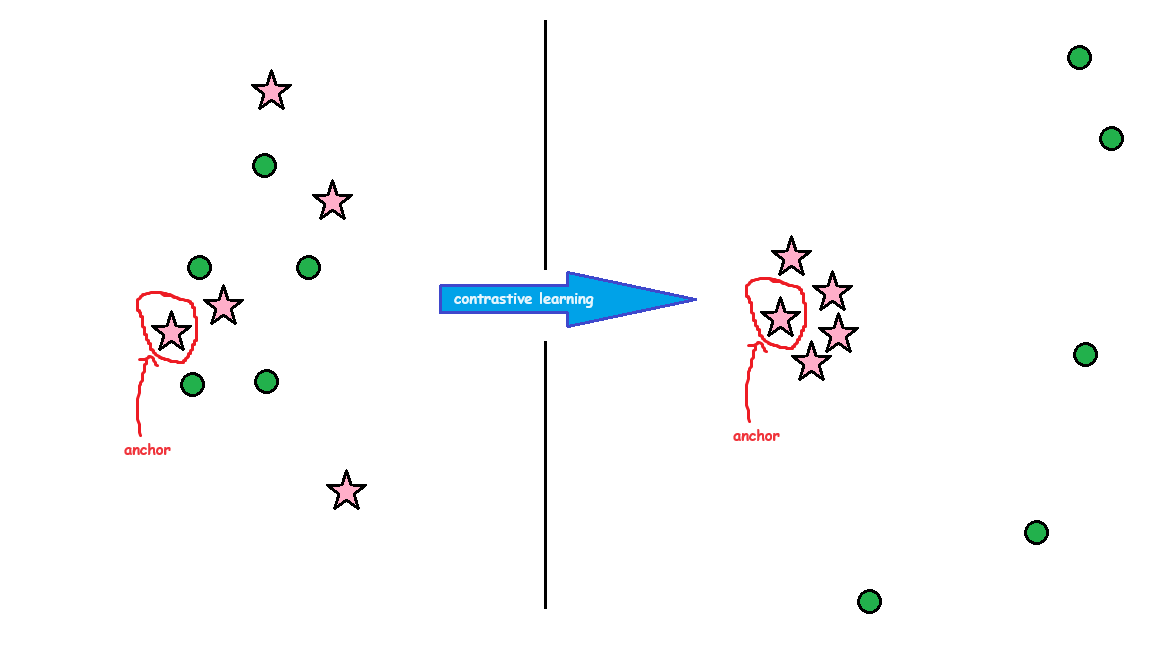

*visualisation of contrastive learning*

The way this was done in CLIP was by taking a massive dataset of image-caption pairs, and then assuming all of the paired images and captions were supposed to be similar, where all other potential image-caption combos were assumed to be dissimilar. When a similar pairing was passed through the model training loop, the model parameters would be updated to make their embeddings sit closer together, and when they were dissimilar, the parameters would update to make the outputs sit further apart.

OpenAI used two completely separate models to achieve this - one for images and one for text. 

Since the text model's embeddings were already trained to be particularly good at "describing" the difference between images, the folks at Stability.AI decided to use this model for their word embeddings!


### Exploring CLiP: the text embedding model
First, let's load the text embedding model:

In [2]:
# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

text_encoder = text_encoder.to(torch_device).half()

To turn a sentence into an embedding, first we must "tokenize" the sentence, which is why we've loaded a Tokenizer.

A tokenizer takes subwords from your input string/sentence, and then, using a dictionary, converts them to integers. Subwords can be as short as a letter, or an entire word.

The reason we turn these into numbers first is to convert text into much smaller chunks of data that can more easily be mathematically operated on. Think of this stage as sort of like a simple code-book where we match certain chunks of words to numbers.

In [3]:
input_sentence=["Hi mum! I'm in a computer!"]

In [4]:

input_sentence = ["Hi mum! I'm in a computer!"]

tokenized_input = tokenizer(
    input_sentence,
    
    # 'padding' is to fill in "unused" tokens in the input, to make sure it goes into our embedding model properly
    padding="max_length",

    # 'max_length' is setting how many tokens the padder needs to pad the input out to
    max_length=tokenizer.model_max_length,
    
    # 'truncation' being true means that, if we put in too many tokens, we will just chop off the last tokens to make sure the input fits
    truncation=True,
    
    # 'return_tensors' set to 'pt' means that our datatype will be compatible with PyTorch
    return_tensors="pt"
)

pprint(tokenized_input)


{'input_ids': tensor([[49406,  1883,  4030,   256,   328,   880,   530,   320, 11639,   652,
           256, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}


You can see that by calling `tokenizer()`, the text was converted to a list of numbers (a tensor), the `input_ids` field. The `attention_mask` is used to tell the model which input tokens are actually text, vs. padding or other input parts that should be ignored by the model.

These tokenised outputs can easily be "reversed", to get our inputs back.


In [5]:

tokenizer.decode(
    # We pass in the 'input_ids' field (we don't need the `attention_mask` field here.
    # The [0] is needed because we could have tokenized many text strings at once (we didn't though)
    tokenized_input['input_ids'][0],

    # XXX - AJS - will can you explain this arg
    skip_special_tokens=True
)


"hi mum! i'm in a computer!"

Now we will "embed" these tokens into their embedding space

In [6]:

# Move the tokenized text to the processing device (GPU or CPU etc.)
tokenized_input = tokenized_input.to(torch_device)
sentence_embedding = text_encoder(**tokenized_input)

Now let's look at that shall we?

In [7]:
print(sentence_embedding)

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4902, -0.3066,  0.0674],
         [ 0.4297, -1.1533, -1.0186,  ..., -0.3411, -0.4497, -1.2920],
         [-1.0508,  0.8071, -1.4277,  ..., -0.5166,  1.0107,  0.9146],
         ...,
         [ 0.0632,  0.6182, -0.3821,  ..., -0.2637, -0.4199,  0.3838],
         [-0.0268,  0.4519, -0.2959,  ..., -0.3071, -0.3857,  0.2986],
         [-0.6709,  1.0703, -0.4839,  ...,  0.5630, -0.5439, -0.1895]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-4.5044e-01,  1.1367e+00, -7.3486e-01,  1.2295e+00,  1.1514e+00,
          9.9854e-01, -5.2832e-01, -9.7266e-01, -3.8989e-01, -6.5125e-02,
         -9.2285e-01,  1.5479e+00,  4.2786e-02, -8.6914e-01,  1.9014e+00,
         -1.7859e-01, -8.5938e-01,  1.8604e-01, -1.1641e+00,  6.5273e+00,
         -6.8994e-01,  9.7510e-01, -1.3975e+00,  2.6660e-01,  1.8005e-02,
         -6.5723e-01, -1.7609e-02, -8.4424e-01,

What you'll see printed out is two items - the top item is the "unpooled output" of the embedding model, and the bottom output is the "pooled" output. Essentially what's happening is that each token itself is getting an embedding assigned to it, and then all of those embeddings get averaged together in a sentence. This first unpooled output is the one we'll be putting into our UNet later.

Two things worth noting here - one is that it's now much trickier to decode this set of numbers back into the input sentence. This is an encoder-only network, and typically the only way to turn this set of number back into a sentence is to use a decoder network trained to decode this embedding. This model does not come with that component attached - [however, community-driven open-source efforts have been made to train a separate decoder, if you are curious to see what that looks like.](https://github.com/fkodom/clip-text-decoder)

Two is that this is a set of numbers - and in that sense, you can sort of do an arbitrary amount of arithmetic on it to create whatever set of numbers you like! You could, for example, add 1 to all of the numbers in the vector embeddings, or multiply all the numbers, or add another vector, or completely randomise them! This is potentially an interesting way of exercising control over your final output in an LDM - however, we can start playing around with that later in the series, when we've got our entire text-to-image cascade up and running.

If you'd like - I've written a few fun functions that will do everything I just demonstrated, but with your own inputs. I'll use these later in this explainer series, but feel free to play around with them for now.

In [8]:

def tokenize(stringlist):
    """Convert a list of strings into a tensor of tokenized strings"""
    tokenized = tokenizer(stringlist, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    return tokenized

def detokenizer(tokenized):
    """Decode a single tokenized string
    
    AJS - will should this be adjusted to handle an entire batch like tokenize() above?
    """
    return tokenizer.decode(tokenized['input_ids'][0], skip_special_tokens=True)

def sentence_embedder(stringlist):
    """Tokenize, then embed a list of strings"""
    inputs=tokenize(stringlist)
    inputs=inputs.to(torch_device)
    with torch.no_grad():
        sentence_embeddings=text_encoder(**inputs)
    return sentence_embeddings
    

In [193]:

demo_strings = [
    'demo string! The meaning of life is 42 (and so am I in spirit - 42 years old. Time flies.)',
    'This is another text string!'
]

tokenized=tokenize(demo_strings)
decoded=detokenizer(tokenized)
embeddings=sentence_embedder(demo_strings)

print(demo_strings)
print('')
print(tokenized)
print('')
print(decoded)
print('')
print(embeddings)


['demo string! The meaning of life is 42 (and so am I in spirit - 42 years old. Time flies.)', 'This is another text string!']

{'input_ids': tensor([[49406,  7380,  9696,   256,   518,  8342,   539,   970,   533,   275,
           273,   263,   537,   706,   687,   328,   530,  4071,   268,   275,
           273,  1151,   896,   269,   788,  8070,  5376, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406,   589,   533,  1380,  4160,  9696,   256, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         

In [9]:
# ADD SILLY FUNCTIONS TO PLAY WITH HERE

Now that we understand the text embedder, let's move on to the Variational AutoEncoder. *make this a link*

## ADVANCED/OPTIONAL: Exploring CLiP: the image encoder and similarity measurement

As mentioned at the beginning, the CLiP model was originally designed to allow for us to search for images with text - images similar to the text would sit very close to the original text embedding, whereas dissimilar images would sit far apart.

This part of the notebook is optional, since this component of CLiP isn't used in Stable Diffusion at all, but if you would like to understand the CLiP model as a whole, let's continue!

Let's start by loading new packages for this optional part of the tutorial

In [140]:
from transformers import CLIPVisionModelWithProjection, CLIPVisionModel, AutoProcessor
from PIL import Image
import requests
from io import BytesIO

Now let's load the model as well as the image processor - in this case, the image processor is essentially the tokenizer from earlier, but for images rather than text

In [83]:
image_model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14")
image_model = image_model.to(torch_device).to(torch.float16) #move to inference device, halve the precision for better inference speed

processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")

Now let's load an image to embed - for absolutely no reason, here is a picture of Elon Musk

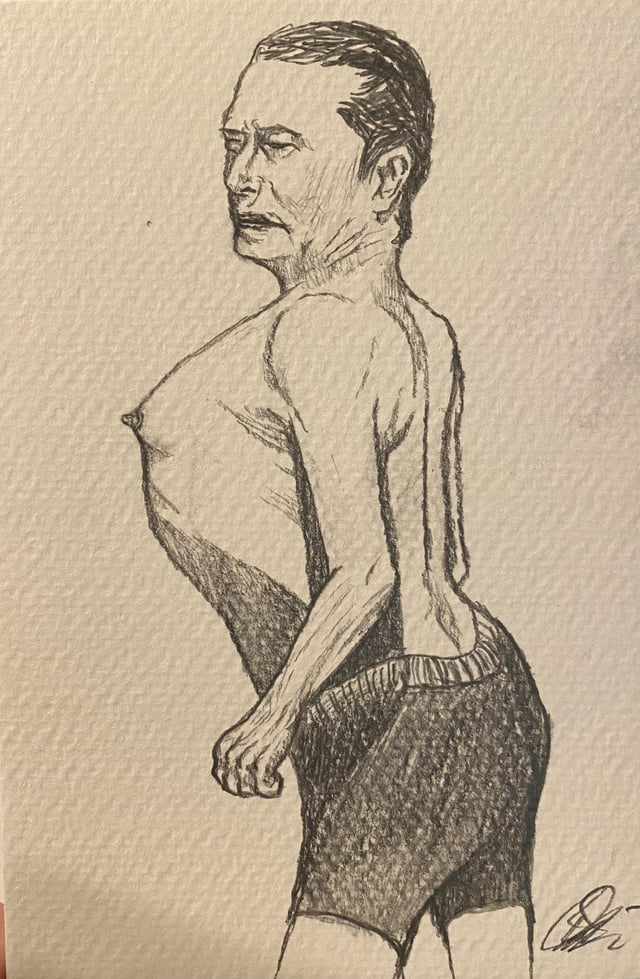

In [113]:
elon_url = "https://preview.redd.it/im-a-little-late-but-this-is-my-drawing-of-elon-musk-in-his-v0-zeuw69y9amg91.jpg?width=640&crop=smart&auto=webp&s=f670391a09baf96578b2d363fdb9a3c998c4d0be"
elon_request = requests.get(elon_url)
elon_img = Image.open(BytesIO(elon_request.content))

elon_img

And let's process this image - similar to tokenizing the sentence from earlier, this image has to be turned into a set of numbers that the CLIP Image Model understands

In [108]:
image_inputs = processor(images=elon_img, return_tensors="pt")

In [110]:
image_inputs = image_inputs.to(torch_device).to(torch.HalfTensor)

Before we continue, let's take a quick look at the shape of the input data, and compare it to our original data

In [111]:
print(f"the original image is {elon_img.size}")
print(f"The processed image input is {image_inputs['pixel_values'].shape}")

the original image is (640, 979)
The processed image input is torch.Size([1, 3, 224, 224])


Worth noting here is the "resolution" here - the input image is 224x224 in resolution, with 3 channels (RGB). Our original image is definitely not the same size, at 640x979. This is because the CLiP image model **has to take in an input image resolution of 224x224*. Although this is outside of the scope of this tutorial, consider how this might affect/limit the image embedding model.

Anyhow - let's run the model:

In [112]:
image_outputs=image_model(**image_inputs)
image_outputs

BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 0.1636, -0.2112,  0.0934,  ...,  0.3335, -0.7705, -0.4272],
         [ 0.2195,  0.7900,  0.5776,  ...,  0.7256,  0.9648,  0.1106],
         [ 0.5059,  1.4092, -0.2959,  ..., -0.3240,  0.4404,  0.1608],
         ...,
         [ 0.5444,  1.1797,  0.8193,  ..., -0.6606,  0.4209,  0.3145],
         [ 1.0469,  1.3008, -0.0831,  ..., -0.0154,  0.3552, -0.0534],
         [ 0.7749,  0.1581,  0.2427,  ...,  0.1224,  1.0010,  0.1230]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>), pooler_output=tensor([[ 0.3105, -0.2522,  0.1328,  ...,  0.8257, -1.5000, -0.8491]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

In [116]:
print(f'The shape of the last hidden state is {image_outputs.last_hidden_state.shape}')
print(f'The shape of the pooled output is {image_outputs.pooler_output.shape}')

The shape of the last hidden state is torch.Size([1, 257, 1024])
The shape of the pooled output is torch.Size([1, 1024])


What you'll notice here is the same as before with our text model - we have a last_hidden_state output and a pooler_output. The first one is each individual "token"'s embedding (sort of like the 77 tokens we had earlier in the sentence embedder), and the last one is the pooled output - or the element-wise averaged embedding.

The other thing worth pointing out is the dimensionality of the embeddings. At the moment, a single token's embedding here has 1024 dimensions. You may remember that the text embedder had an embedding shape of 768 for each token (so pooled would be 1,768). Obviously, to be able to compare embeddings in the same space, you'll need them to be the exact same dimensions - this is where a projection layer comes in, which takes our 1024 dimensions, and then remaps them to 768, while preserving as much information as possible.

We'll load the projection layer now:

In [156]:
image_model_with_projection = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-large-patch14")
img_projection_layer = image_model_with_projection.visual_projection.to(torch_device).to(torch.float16)

and now let's create our final embedding of Elon Musk;

In [139]:
elon_img_embedding = img_projection_layer(image_outputs.pooler_output)
elon_img_embedding

torch.Size([1, 768])

Great! Now that that's done, we should be able to compare these to the text embeddings. BUT there's one more step.

Although the text embedder outputs into 768 dimensions (and therefore a projection is mathematically unnecessary), it actually still needs a projection layer to map the raw text embedder outputs to shared image-text embedding space, since that was a discrete layer trained during the training process, that transforms the 768-dimensional embedding into the shared text-image embedding space. We'll load that now, since we'll be using that pretty soon:

In [144]:
from transformers import CLIPTextModelWithProjection
text_encoder_with_projection = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14")
text_projection_layer = text_encoder_with_projection.text_projection.to(torch_device).to(torch.float16)

#### Measuring the distance between text and image embeddings

We've got all of our components loaded, which will allow us to do what we've been talking about this whole time - compare text and image embeddings. But one final bit of knowledge before we crack on - how do we actually measure "distance" in this context?

If you're a Natural Language Processing (NLP) connoisseur, you'd be familiar with [Cosine Similarity](https://www.sciencedirect.com/topics/computer-science/cosine-similarity#:~:text=Cosine%20similarity%20measures%20the%20similarity,document%20similarity%20in%20text%20analysis.) as a distance metric - which is what is used in the CLiP model. For the uninitiated, this is a metric that measures the *angle* between two vectors in vector space, rather than our more intuitive, traditional understanding of distance (i.e. [Euclidean Distance](https://byjus.com/maths/euclidean-distance/), or being incredibly reductive, the pythagorean theorem generalised). Historically cosine similarity was favoured in NLP given that most approaches to tokenisation/embedding resulted in creating [sparse vectors](https://milvus.io/docs/sparse_vector.md) (vectors with lots of zero values), which meant that embeddings with lots of non-zero values would artificially be clumped close together purely because the vectors were "bigger", regardless of what the actual text was. Now, given more advanced modelling techniques that return [dense vectors](https://medium.com/@yasindusanjeewa8/dense-vectors-in-natural-language-processing-06818dff5cd7) (vectors with almost entirely non-zero values), this choice is mostly arbitrary, with several other metrics that can also be used in this space effectively (e.g. dot-product, euclidean distance, L1 distance). **In this case, however, the model was trained with cosine similarity as the distance metric, so we will use this at inference**.

Now, with that out of the way, let's import and define our distance metric:

In [170]:
from torch.nn import CosineSimilarity

cos_sim=CosineSimilarity()

Next we'll define functions that return our projected embeddings:

In [171]:
def proj_sentence_embedder(stringlist):
    inputs=tokenize(stringlist)
    inputs=inputs.to(torch_device)
    with torch.no_grad():
        sentence_embeddings=text_encoder(**inputs)
        proj_sentence_embeddings=text_projection_layer(sentence_embeddings[1])
    return proj_sentence_embeddings.cpu().detach()

def proj_image_embedder(img_url):
    img_request = requests.get(img_url)
    input_img = Image.open(BytesIO(img_request.content))
    image_inputs = processor(images=input_img, return_tensors="pt")
    image_inputs = image_inputs.to(torch_device).to(torch.HalfTensor)
    pool_outputs = image_model(**image_inputs).pooler_output
    img_embedding = img_projection_layer(pool_outputs)
    return img_embedding.cpu().detach()

Now let's run our text similarity analysis on our existing elon musk embedding, with this series of text prompts:

- A pencil drawing of elon musk
- a highly successful, influential man
- a balm to humanity, the harbinger of great progressive change
- dog

We'll visualise our results in a plot as well

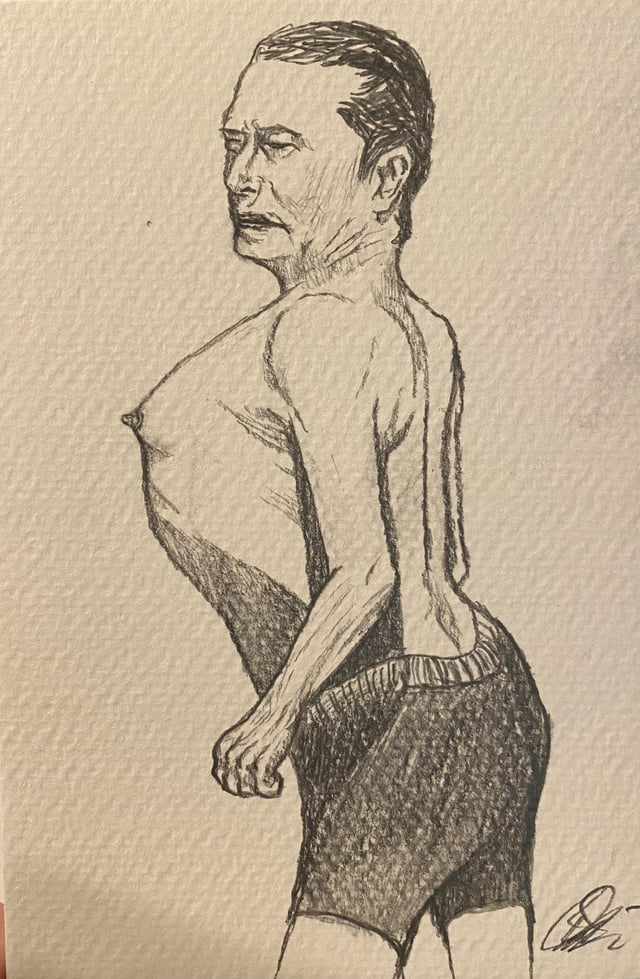

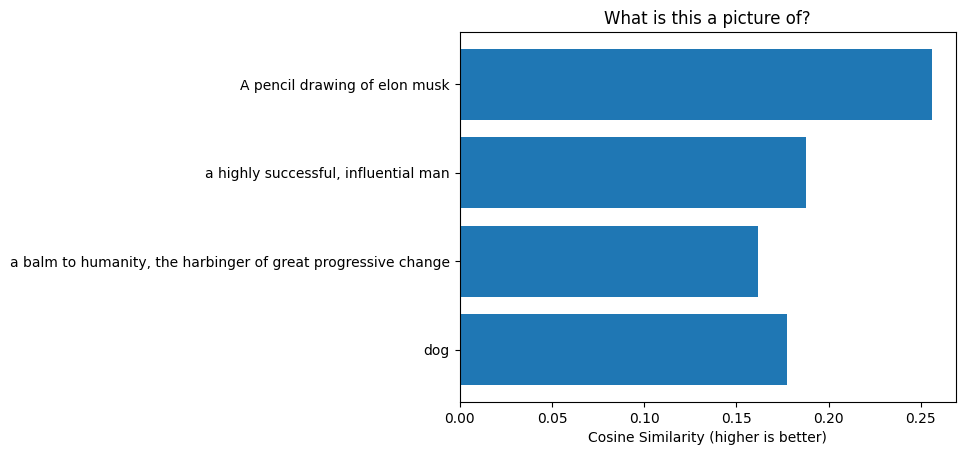

In [191]:
import matplotlib.pyplot as plt
import numpy as np


def CLIP(caption_candidates, img_URL):
    img_request = requests.get(img_URL)
    display_img = Image.open(BytesIO(img_request.content))

    
    img_embedding=proj_image_embedder(img_URL)
    
    caption_embeddings = proj_sentence_embedder(caption_candidates)
    
    output_cos_sims = cos_sim(img_embedding.cpu().detach(), caption_embeddings)
    
    output_cos_sims_lst = list(output_cos_sims)
    
    #create plots for distance
    fig, ax = plt.subplots()
    
    y_pos=np.arange(len(caption_candidates))
    
    ax.barh(y_pos, output_cos_sims_lst, align='center')
    ax.set_yticks(y_pos, labels=caption_candidates)
    ax.invert_yaxis()
    ax.set_xlabel('Cosine Similarity (higher is better)')
    ax.set_title('What is this a picture of?')
    
    display(display_img)
    plt.show()

CLIP(
    caption_candidates = ['A pencil drawing of elon musk', 'a highly successful, influential man', 'a balm to humanity, the harbinger of great progressive change', 'dog'],
    img_URL = "https://preview.redd.it/im-a-little-late-but-this-is-my-drawing-of-elon-musk-in-his-v0-zeuw69y9amg91.jpg?width=640&crop=smart&auto=webp&s=f670391a09baf96578b2d363fdb9a3c998c4d0be"
)

Well look at that - the caption with the highest cosine similarity is the correct one - "A pencil drawing of elon musk"! Looks like it's working as intended. 

And that's the whole CLiP model explained! Feel free to play around with your own text and image inputs below:

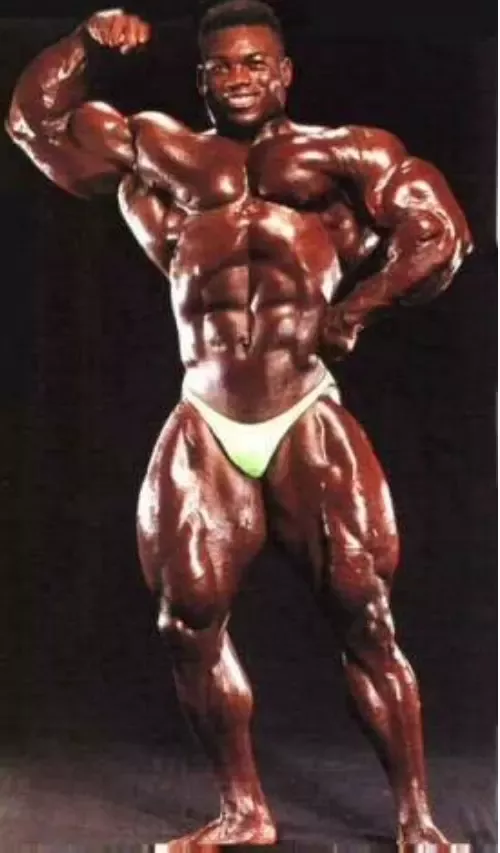

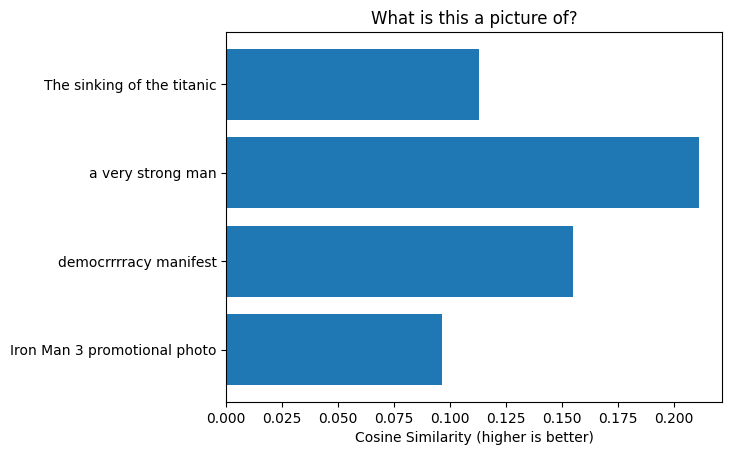

In [192]:
CLIP(
    caption_candidates = ['The sinking of the titanic', 'a very strong man', 'democrrrracy manifest', 'Iron Man 3 promotional photo'],
    img_URL = "https://qph.cf2.quoracdn.net/main-qimg-3235c2e300659c11539b50be46249825.webp"
)